In [8]:
# test file implementation of regularization of damage (d) using lipschitz constraints
import numpy as np
import scipy
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint


### Material and geometry inputs

In [9]:
# Material parameters

E = 275.0*10**9     # Young's module (Pa)
Gc = 100.0          # Fracture energy


# Geometry parameters

L = 1.05*10**-3     # Bar length
x0 = 0              # Left extremitiy x coordinate / 0-initial
xf = L              # Rigth extremitiy x coordinate / f-final


# Mesh

n_el = 21           # Number of elements
hun = L/n_el        # Element length
# Points coordinates for a uniform mesh
node_coord = np.linspace(x0, xf, n_el+1)
# Coordenates of integration points
x = [hun*i + hun*0.5 for i in range(n_el)]

# Data for test damage peak at the middle of the bar
# A fabricated damage field
dn = [0., 0.0473944, 0.0898275, 0.127299, 0.15981, 0.187359, 0.209947, 0.227574,  0.24024,  0.247944,0.250687, 0.248469, 0.24129,  0.229149, 0.212047, 0.189984, 0.16296, 0.130974, 0.0940275, 0.0521194, 0.00525]
# A fabricate critical stress field
stress_critical = 300.0*10**4
sigmac = [(abs(node_coord[i]-L/2)**0.5)/((L/2)**0.5 /
                                         (stress_critical*3)) + stress_critical for i in range(n_el)]

strain = 5*10**-5   # Assuming constant strain
 

### Regularization of damage inputs

In [10]:
# Regularization inputs

n_element_reg = 14          # Number of elements in the regularization 
l = n_element_reg * hun     # Regularization length
w = 2.                      # Weight quadrature

# Energy release rate
Yc = [sigmac[el]**2 / (2.*E) for el in range(n_el)] 
# Constant lambda 
lamb = [2. * Yc[el] * l / Gc for el in range(n_el)]  
# Softening function
def h(lamb,d): return (2*d - d**2) / (1 - d + lamb * d**2) **2

# Functional to minimize 
def func(d): return w*sum([
            (0.5*(1. - d[el])** 2 * 
            E*strain**2 + 
            Yc[el] * 
            h(lamb[el], d[el])) * 
            hun/2.
            for el in range(n_el)
    ])


def func_interval(d, n_inf, n_sup): 
    
    return w*sum([
    (0.5*(1. - d[el])** 2 * 
    E*strain**2 + 
    Yc[el] * 
    h(lamb[el], d[el])) * 
    hun/2.
    for el in range(n_inf, n_sup)
    ])

In [11]:
def ComputeProjections(dp):
    
    lower = np.zeros(n_el)
    upper = np.zeros(n_el)

    for el in range(n_el):
        upper_opt = minimize(
            lambda y: -dp[np.searchsorted(node_coord, y[0])-1] + abs(x[el]-y[0])/l,
            x0=0.5*L,
            method='SLSQP',
            bounds=[(x0, xf)],
            tol=1e-6
        )
        if upper_opt.success == False:
            raise Exception('upper projection damage predictor failed')
        upper[el] = - upper_opt.fun

        lower_opt = minimize(
            lambda y: dp[np.searchsorted(node_coord, y[0])-1] + abs(x[el]-y[0])/l,
            x0=0.5*L,
            method='SLSQP',
            bounds=[(x0, xf)],
            tol=1e-6
        )
        if lower_opt.success == False:
            raise Exception('lower projection damage predictor failed')
        lower[el] = lower_opt.fun
    
    return upper, lower

### Compute damage next time-step

In [12]:
d_next = np.zeros(n_el)
small_number = 10e-5

# Compute damage predictor: Optimization without constraints 
dp_opt = minimize(
    fun=func,
    x0=dn,
    method='SLSQP',
    bounds=zip(dn, [1.]*n_el),
    tol=1e-6,
)
if dp_opt.success == False:
    raise Exception('optimization damage predictor failed')

dp = dp_opt.x

# Compute projections
upper, lower = ComputeProjections(dp)

sup = upper - lower
for el in range(n_el):
    if sup[el] < small_number:
        sup[el] = 0
# print(sup)

region_opt = []
dn_region_opt = []

for el in range(n_el):

    # If projections are superposed
    if (upper[el] - lower[el] < small_number):
        d_next[el] = dp[el]


    # If the projections are different
    else:
        region_opt.append(el)
        dn_region_opt.append(dn[el])


func_intt = lambda damage: func_interval(damage, 0, n_el)
At = scipy.sparse.eye(n_el - 1, n_el) - scipy.sparse.eye(n_el-1, n_el, 1)
bt = hun/l
constt = LinearConstraint(At, -bt * np.ones(n_el-1), bt * np.ones(n_el-1))
bound_inft = [dn[el] for el in range(n_el)]
bound_supt= [1. for el in range(n_el)]

dlip_optt = minimize(
    fun=func_intt,
    x0=bound_inft,
    method='SLSQP',
    bounds=zip(bound_inft, bound_supt),
    tol=1e-6,
    constraints=constt,
)
# print(dlip_optt)
if dlip_optt.success == False:
    raise Exception('optimization failed')
    
d_nextt = dlip_optt.x

print(region_opt)
print(dn_region_opt)



def func_test(d): 
    
    return w*sum([
    (0.5*(1. - d[el])** 2 * 
    E*strain**2 + 
    Yc[el + 8] * 
    h(lamb[el + 8], d[el])) * 
    hun/2.
    for el in range(len(dn_region_opt))
    ])



# func_int = lambda damage: func_interval(damage, region_opt[0], max(region_opt)+1)
# A = scipy.sparse.eye(len(region_opt) - 1, len(region_opt)) - scipy.sparse.eye(len(region_opt)-1, len(region_opt), 1)
# b = hun/l
# const = LinearConstraint(A, -b * np.ones(len(region_opt)-1), b * np.ones(len(region_opt)-1))
# # Bounds
# bound_inf = [dn[el] for el in range(region_opt[0], max(region_opt)+1)]
# bound_sup = [1. for el in range(len(region_opt))]
# func_int = lambda damage: func_interval(damage, region_opt[0], max(region_opt)+1)
A = scipy.sparse.eye(4, 5) - scipy.sparse.eye(4, 5, 1)
b = hun/l
const = LinearConstraint(A, -b * np.ones(4), b * np.ones(4))
# Bounds
bound_inf = [dn[el] for el in range(8, 12+1)]
bound_sup = [1. for el in range(5)]


dlip_opt = minimize(
    fun=func_test,
    x0=bound_inf,
    method='SLSQP',
    bounds=zip(bound_inf, bound_sup),
    tol=1e-6,
    constraints=const,
)
print(dlip_opt)
if dlip_opt.success == False:
    raise Exception('optimization failed')
    
d_opt = dlip_opt.x
print(d_opt)
print(d_next)

d_next[8] = d_opt[0]
d_next[9] = d_opt[1]
d_next[10] = d_opt[2]
d_next[11] = d_opt[3]
d_next[12] = d_opt[4]

print(d_next)





[8, 9, 10, 11, 12]
[0.24024, 0.247944, 0.250687, 0.248469, 0.24129]
     fun: 0.05840975818942071
     jac: array([ 0.00040598,  0.00079254, -0.00063083, -0.00064845,  0.00075292])
 message: 'Optimization terminated successfully'
    nfev: 37
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.26915104, 0.32265536, 0.39408394, 0.39389534, 0.32246677])
[0.26915104 0.32265536 0.39408394 0.39389534 0.32246677]
[0.06582382 0.08309257 0.10166023 0.127299   0.15981    0.187359
 0.209947   0.2280498  0.         0.         0.         0.
 0.         0.26693324 0.22805132 0.19593744 0.16827935 0.1438183
 0.12178042 0.10165674 0.08309938]
[0.06582382 0.08309257 0.10166023 0.127299   0.15981    0.187359
 0.209947   0.2280498  0.26915104 0.32265536 0.39408394 0.39389534
 0.32246677 0.26693324 0.22805132 0.19593744 0.16827935 0.1438183
 0.12178042 0.10165674 0.08309938]


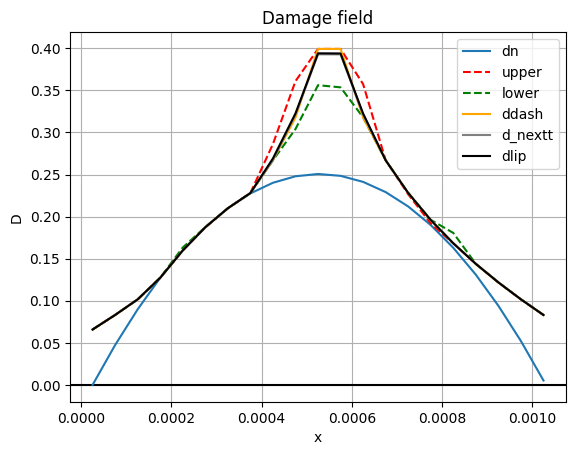

In [13]:
# Plot

def PlotDamage(x, dn, ddash, upper, lower, d_nextt, dlip):
    fig, axes = plt.subplots()
    axes.grid(True, which='both')
    axes.axhline(y=0, color='k')

    plt.title(str("Damage field"))
    plt.xlabel(str("x"))
    plt.ylabel(str("D"))
    plt.plot(x, dn, label='dn')
    plt.plot(x, upper, label='upper', color='red', linestyle = 'dashed')
    plt.plot(x, lower, label='lower', color='green', linestyle = 'dashed')
    plt.plot(x, ddash, label='ddash', color='orange')
    plt.plot(x, d_nextt, label='d_nextt', color='gray')
    plt.plot(x, dlip, label='dlip', color='black')
    plt.legend()
    plt.show()

PlotDamage(x, dn, dp, upper, lower, d_nextt, d_next)